In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/Datasets/LWF_DATASET/lfw.zip

In [1]:
import torch
import os
import cv2
import random
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,random_split
import torchvision.transforms as transforms
import torch.optim as optim

In [2]:
path_lfw_folder='./gdrive/MyDrive/Datasets/LWF_DATASET'

In [3]:
def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')

def save_checkpoint(save_path, model, optimizer, val_acc):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),                    
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_accuracy': val_acc}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer,save_path):
    # save_path = f'siameseNet-batchnorm50.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_acc = state_dict['val_accuracy']
    print(f'Model loaded from <== {save_path}')
    
    return val_acc

In [4]:
# have to investigate the splitting of train/val/test data

In [5]:
class LFW(Dataset):
    def __init__(self,root_dir,txt_path,transform):                 #######  transform aagor khini e use kribo loga hol,,,,, sabo lagibo
        self.transform=transform
        self.root_dir=root_dir

        with open(txt_path) as f:
            lines=f.readlines()

            self.pair_imgs_label=[ line.split() for line in lines]

    def __len__(self):
        return len(self.pair_imgs_label)

    def __getitem__(self,idx):
        img1_path=os.path.join(self.root_dir,self.pair_imgs_label[idx][0])
        img2_path=os.path.join(self.root_dir,self.pair_imgs_label[idx][1])
        label= float(self.pair_imgs_label[idx][2])

        img1=cv2.imread(img1_path)
        img1=img1.astype(np.float)/255                                   ########  aigal aagor khini e use kribo loga hol,,,,, sabo lagibo
        img1=cv2.resize(img1,(224,224),interpolation=cv2.INTER_AREA)
        img1=self.transform(img1)

        img2=cv2.imread(img2_path)
        img2=img2.astype(np.float)/255
        img2=cv2.resize(img2,(224,224),interpolation=cv2.INTER_AREA)
        img2=self.transform(img2)

        return img1,img2,torch.from_numpy(np.array([label], dtype=np.float32))

In [6]:
class Rescale(object):                                          ################################### #######  aigal aagor khini e use kribo loga hol,,,,, sabo lagibo
    def __call__(self, img):
        if random.random()<0.7:
            f = round(0.1*random.randint(7, 13),2)
            if f>1:
                img = cv2.resize(img,None,fx=f, fy=f, interpolation = cv2.INTER_CUBIC)
                a = int(round((f*128-128)/2))
                img = img[a:a+128,a:a+128]
            else:
                img = cv2.resize(img,None,fx=f, fy=f, interpolation = cv2.INTER_AREA)
                a= int(round((128-f*128)/2))
                temp=np.zeros([128,128,3],dtype=np.uint8)
                temp.fill(0) 
                for i in range(img.shape[0]):
                    for j in range(img.shape[1]):
                        temp[i+a,j+a]=img[i,j]
                img=temp
        return img

class Flip(object):
    def __call__(self,img):
        if random.random()<0.7:
            return cv2.flip(img,1)
        return img
        
class Rotate(object):
    def __call__(self,img):
        if random.random()<0.7:
            angle=random.random()*60-30
            rows,cols,cn = img.shape
            M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
            img = cv2.warpAffine(img,M,(cols,rows))
            return img
        return img

class Translate(object):
    def __call__(self,img):
        if random.random()<0.7:
            x=random.random()*20-10
            y=random.random()*20-10
            rows,cols,cn = img.shape
            M= np.float32([[1,0,x],[0,1,y]])
            img = cv2.warpAffine(img,M,(cols,rows))
        return img

In [7]:
# model = torchvision.models.resnet18(pretrained=True)
# newmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
# print(newmodel)

In [8]:
# print(model)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()

        # model_conv=torchvision.models.resnet18(pretrained=True)
        model_conv=torchvision.models.resnet50(pretrained=True)
        for param in model_conv.parameters():
            param.requires_grad=False
        self.num_ftrs=model_conv.fc.in_features

        self.res_net_conv=torch.nn.Sequential(*(list(model_conv.children())[:-1]))

        self.fc=nn.Linear(self.num_ftrs*2,1)

        self.sig_out=nn.Sigmoid()


    def forward(self,x1,x2):
        x1= self.res_net_conv(x1)
        x2= self.res_net_conv(x2)

        x1=x1.view(-1,self.num_ftrs)
        x2=x2.view(-1,self.num_ftrs)

        x=torch.cat((x1,x2),1)
        x=self.fc(x)      ########## have to add a sigmoid layer
        x=self.sig_out(x)
        # For distance function method
        # x=torch.abs(x1-x2)
        # x= self.fc2(x)

        return x

In [10]:
def train(model,train_loader,val_loader,num_epochs,criterion,save_name):
    train_losses=[]
    val_losses=[]
    mx_val_accuracy=-1
    for epoch in range(num_epochs):
        running_loss=0.0
        print("Starting epoch " + str(epoch+1))
        model.train()
        total_no_imgs=0
        for imgs1,imgs2,labels in train_loader:
            imgs1=imgs1.to(device=device, dtype=torch.float)
            imgs2=imgs2.to(device=device, dtype=torch.float)
            labels=labels.to(device=device, dtype=torch.float)

            optimizer.zero_grad()
            outputs=model(imgs1,imgs2)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            total_no_imgs+= imgs1.size(0)
    running_loss+=loss.item()* imgs1.size(0)

    avg_train_loss = float(running_loss) /total_no_imgs 
# avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

val_running_loss=0.0                                                            ########################### 
correct=0
total_no_imgs=0
with torch.no_grad():
model.eval()
for i,data in enumerate(val_loader,0):
imgsV1,imgsV2,labelsV= data

imgsV1=imgsV1.to(device=device, dtype=torch.float)
imgsV2=imgsV2.to(device=device, dtype=torch.float)
labelsV=labelsV.to(device=device, dtype=torch.float)

outputs=model(imgsV1,imgsV2)
loss=criterion(outputs,labelsV)

# val accuracy calc
outputs=outputs.to(device=device, dtype=torch.float)

for j,op in enumerate(outputs,0):
  total_no_imgs+=1
  if(op[0]<0.5):
    #0 predicted
    if labelsV[j]==0:           ###########
      correct+=1
  else:
    # 1 predicted
    if labelsV[j]==1:
      correct+=1
val_running_loss+=loss.item()*imgsV1.size(0)
# val_accuracy= correct/len(val_loader)
# avg_val_loss= val_running_loss/len(val_loader)

val_accuracy= float(correct)/total_no_imgs
avg_val_loss= float(val_running_loss)/total_no_imgs
val_losses.append(avg_val_loss)

## val acc
if mx_val_accuracy<val_accuracy:
mx_val_accuracy=val_accuracy
save_checkpoint(save_name, model, optimizer, mx_val_accuracy)

print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'.format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))

print("Training completed.")

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(train_losses)
ax.plot(val_losses)     ###############3
plt.xlabel('Steps')  
plt.ylabel('Loss')  
fig.savefig(os.path.join(path_lfw_folder,'Loss_Steps.png')) 

return train_losses,val_losses,mx_val_accuracy


In [11]:
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Rescale(),Flip(),Translate(),Rotate(),

# train_dataSize = 2200 # self-defined dataset size for training                                                              
# TRAIN_PCT = 0.8 # percentage of entire dataset for training
# train_size = int(train_dataSize * TRAIN_PCT)
# val_size = train_dataSize - train_size   
path_lfw_folder='./gdrive/MyDrive/Datasets/LWF_DATASET' 
path_to_img_dir= './lfw/lfw'

train_txt_path = os.path.join(path_lfw_folder,'Final_lfw_train_pairs.txt')
valid_txt_path = os.path.join(path_lfw_folder,'Final_lfw_valid_pairs.txt')
test_txt_path  = os.path.join(path_lfw_folder,'Final_lfw_test_pairs.txt')                                                                     

train_set = LFW('./lfw/lfw',train_txt_path,transform)                                
val_set = LFW('./lfw/lfw',valid_txt_path,transform)

# train_set, val_set = random_split(lfw_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=8 , num_workers=0)    ################## batch size ... 12
val_loader   = DataLoader(val_set, batch_size=2, shuffle=True, num_workers=0)

In [12]:
if torch.cuda.is_available():
  device='cuda:0'
  print('Running on gpu')
else:
  device='cpu'
  print('Running on cpu')

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.001  
num_epoches = 50    
siameseBaseModel=Net()
siameseBaseModel.to(device)

optimizer = optim.Adam(siameseBaseModel.fc.parameters(), lr)
criterion = nn.BCELoss()        ############## have to change it
save_path=os.path.join(path_lfw_folder,'siameseBaseModel.pt')

count_parameters(siameseBaseModel)

Running on gpu
The model architecture:

 Net(
  (res_net_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsampl

Starting epoch 1
Model saved to ==> ./gdrive/MyDrive/Datasets/LWF_DATASET/siameseBaseModel.pt
Epoch [1/50],Train Loss: 0.7526, Valid Loss: 0.68709341
Starting epoch 2
Epoch [2/50],Train Loss: 0.7008, Valid Loss: 0.70210218
Starting epoch 3
Epoch [3/50],Train Loss: 0.6741, Valid Loss: 0.71828022
Starting epoch 4
Epoch [4/50],Train Loss: 0.6553, Valid Loss: 0.73321618
Starting epoch 5
Epoch [5/50],Train Loss: 0.6404, Valid Loss: 0.74671287
Starting epoch 6
Epoch [6/50],Train Loss: 0.6280, Valid Loss: 0.75894863
Starting epoch 7
Epoch [7/50],Train Loss: 0.6174, Valid Loss: 0.77013587
Starting epoch 8
Epoch [8/50],Train Loss: 0.6079, Valid Loss: 0.78045462
Starting epoch 9
Epoch [9/50],Train Loss: 0.5994, Valid Loss: 0.79004736
Starting epoch 10
Epoch [10/50],Train Loss: 0.5916, Valid Loss: 0.79902594
Starting epoch 11
Epoch [11/50],Train Loss: 0.5843, Valid Loss: 0.80747892
Starting epoch 12
Epoch [12/50],Train Loss: 0.5776, Valid Loss: 0.81547757
Starting epoch 13
Epoch [13/50],Train Los

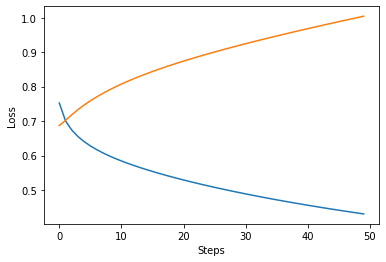

In [13]:
train_loss_his,val_loss_his,mx_val_accuracy_train=train(siameseBaseModel,train_loader,val_loader,num_epoches,criterion,save_path)

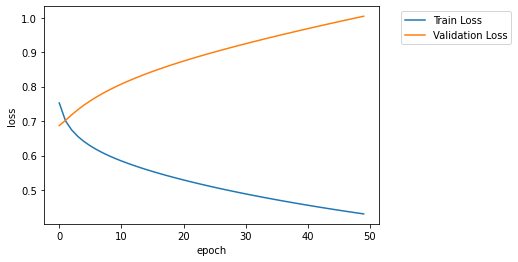

In [14]:
#plotting of training and validation loss                          ########################### 
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_his, label='Train Loss')
plt.plot(val_loss_his, label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [15]:
def test(model,test_loader):
    with torch.no_grad():
      model.eval()
      correct=0
      cnt=0
      print("strating testing:")        
      for i,data in enumerate(test_loader,0):
        imgs1,imgs2,labels=data
        
        imgs1=imgs1.to(device=device, dtype=torch.float)
        imgs2=imgs2.to(device=device, dtype=torch.float)
        labels=labels.to(device=device, dtype=torch.float)

        outputs=model(imgs1,imgs2)
        # test accuracy calc
        outputs=outputs.to(device=device, dtype=torch.float)
        for j,op in enumerate(outputs,0):
          cnt+=1
          if(op[0]<0.5):
            #0 predicted
            if labels[j]==0:           ###########
              correct+=1
          else:
            # 1 predicted
            if labels[j]==1:
              correct+=1
    test_accuracy= correct/cnt

    return test_accuracy


In [16]:
root_path_to_saved_models='./gdrive/MyDrive/Datasets/LWF_DATASET/'
path_to_model_from_saved_model_dir='siameseBaseModel.pt'
path_to_chosen_model= os.path.join(root_path_to_saved_models,path_to_model_from_saved_model_dir)
# print(path_to_chosen_model )

In [17]:
load_model=Net().to(device)
load_optimizer=optim.Adam(load_model.fc.parameters(),lr=0.001)                  #######################################????????/
mx_val_acc=load_checkpoint(load_model,load_optimizer,path_to_chosen_model)

transform = transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


test_set= LFW('./lfw/lfw',test_txt_path,transform)
test_loader= DataLoader(test_set,batch_size=4,num_workers=2)

train_accuracy= test(load_model,train_loader)
test_accuracy=test(load_model,test_loader)


print("Train accuracy is: ",100*train_accuracy)
print("Max val accuracy during training: ",100*mx_val_acc)
print("Test accuracy is: ",100*test_accuracy)

Model loaded from <== ./gdrive/MyDrive/Datasets/LWF_DATASET/siameseBaseModel.pt
strating testing:
strating testing:
Train accuracy is:  73.20855614973262
Max val accuracy during training:  58.78787878787879
Test accuracy is:  53.300000000000004


# with resnet 18
Train accuracy is:  73.01136363636364                                        

Max val accuracy during training:  57.49999999999999

Test accuracy is:  54.50000000000001

